In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import _pickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
import time
import os
import peakutils

from ourfunctions_v3 import clean_nan_samples, remove_noise

In [2]:
# path = "D:/GitHub/Machine-Learning/Kaggle/"
path = "C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/"
savepath = path + 'Kaggle classifiers/new/'
path_results = path + 'Kaggle_results/'

ncpu = os.cpu_count()
if (ncpu>2): njobs = ncpu - 2; 
else: njobs = 1;
    
zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
df_train = _pickle.loads(zf.open('TrainData.pkl').read())
zf.close()

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read())
zf.close()

df_train = remove_noise(df_train)

# Extract data (spectra) and targets of the df_train set
data = df_train.iloc[:,-2:]
targets = df_train.iloc[:,1:-2]

# Then, split into a train and test_train set
data_train, data_test_train, targets_train, targets_test_train = train_test_split(data, targets, test_size=0.3, random_state=11) # split the data
print('Training samples: '+str(len(data_train))+' and test_train samples: ' + str(len(data_test_train)) )

Training sample 339  eliminated
Training sample 490  eliminated
Training samples: 359 and test_train samples: 155


In [3]:
def spectrum_in_bins_6(df, m, M, bin_size): # allows binsize < 1
    
    range_min = []; range_max = []; range_mean = []
    for mz in np.arange(m,M,bin_size):
        range_min.append(mz)
        range_max.append(mz+bin_size)
        range_mean.append(np.mean([range_min[-1],range_max[-1]]))
    N = len(df)  # number of samples
    L = len(range_min)  # length of new spectrum (number of bins)
    all_data = np.zeros((N,L))
    for idx in range(N):
        intensity = df[['intensity']].iloc[idx].values[0]
        mzcoord   = df[['coord_mz']].iloc[idx].values[0]
        interpolated_spectrum = np.interp(x=range_mean,xp=mzcoord,fp=intensity)
        idx_data_in_bins = np.zeros((L,))
        for i,mz in enumerate(range_min):
            intensity_range = intensity[(mzcoord > mz) & (mzcoord < (mz+bin_size))]
            if len(intensity_range) > 0 :
                # as we are interested in peak values, let's keep the maximum value in the interval
                idx_data_in_bins[i] = np.max(intensity_range)
            else: # if those mz coordinates are not in that spectrum we interpolate
                idx_data_in_bins[i] = interpolated_spectrum[i]

        # Remove baseline
        idx_data_in_bins -= peakutils.baseline(idx_data_in_bins,deg=4)
        # Normalize the amplitude of the spectrum
        idx_data_in_bins = idx_data_in_bins / np.max(idx_data_in_bins)
        # Store in matrix
        all_data[idx,:] = idx_data_in_bins.reshape(1,-1)
    new_df = pd.DataFrame(data=all_data, columns = range_mean, index = df.index)
    print('DONE!')
    return new_df

In [5]:
m = 2000; M = 12000; bin_size = 1;

spectrum_train = spectrum_in_bins_6(data_train,m,M,bin_size)
spectrum_test_train = spectrum_in_bins_6(data_test_train,m,M,bin_size)
print('Spectrum regularized!')

DONE!
DONE!
Spectrum regularized!


In [10]:
def try_clf(clf, params, spectrum_train, targets_train, n_cv=5, njobs=5,
            FEATURE_SELECTION=False, feature_vector_list=None):  
    # new version --> Incorporates feature selection
    t1 = time.time()

    best_classifiers = []
    grid_list = []
    AUC_train = []; AUC_valid = []

    categories = targets_train.columns[:]
    for c, cat in enumerate(categories):

        print([cat])  # indicate in which antibiotic we are

        # Selection of train and test data (depending on whether there are NaN target values)
        X_train, Y_train = clean_nan_samples(spectrum_train, targets_train, c, cat)

        if FEATURE_SELECTION:  # a boolean that decides whether to apply feature selection
            # (feature list has to be already defined, and input to the function)
            X_train = apply_feature_selection(X_train, feature_vector_list[c])

        # perform a GridSearchCV in order to train a classifier for this antibiotic
        grid = GridSearchCV(clf, param_grid=params, scoring='roc_auc', n_jobs=njobs, iid=False,
                            pre_dispatch='2*n_jobs', cv=n_cv, return_train_score=True)
        grid.fit(X_train, Y_train)

        # print the best parameters (to detect edge values), and save that classifier
        print('The best parameters are: ', grid.best_params_)
        best_clf = grid.best_estimator_
        best_classifiers.append(best_clf)
        grid_list.append(grid)

        best_clf = np.where(grid.cv_results_['rank_test_score'] == 1)[0][0]
        AUC_train.append(grid.cv_results_['mean_train_score'][best_clf])
        AUC_valid.append(grid.cv_results_['mean_test_score'][best_clf])

        print('Train AUC: ', np.round(AUC_train[-1], 4), ' and validation AUC: ', np.round(AUC_valid[-1], 4))

    avg_AUC_train = np.mean(AUC_train)
    avg_AUC_valid = np.mean(AUC_valid)
    print('\n\nThe average train AUC is', np.round(avg_AUC_train, 4), 'and the avg validation AUC is',
          np.round(avg_AUC_valid, 4))

    t2 = time.time()
    print('\nFull execution took ', np.round(t2 - t1, 1), 'seconds')
    print('\nDONE!')
    return best_classifiers, grid_list, AUC_train, AUC_valid

In [11]:
def get_test_score(clf_list, spectrum_test, targets_test):
    AUC_test = []
    categories = targets_test.columns[:]
    for c, cat in enumerate(categories):
        X_test, Y_test = clean_nan_samples(spectrum_test, targets_test, c, cat)
        pred = clf_list[c].predict_proba(X_test)[:,1]
        AUC_test.append(roc_auc_score(Y_test, pred))
    return AUC_test

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### Logistic Regressor

In [13]:
clf = LogisticRegression(max_iter=1e6, solver='lbfgs',class_weight='balanced')
params = {'C':[0.1,1,10,100,1000]}
lr_best_clfs, lr_grid_list, lr_AUC_train, lr_AUC_validation = try_clf(clf,params,spectrum_train,targets_train,njobs=njobs)

['OXACILINA']
The best parameters are:  {'C': 100}
Train AUC:  0.9973  and validation AUC:  0.8615
['AMIKACINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9792  and validation AUC:  0.81
['AMOXI/CLAV']
The best parameters are:  {'C': 100}
Train AUC:  0.9977  and validation AUC:  0.854
['CIPROFLOXACINO']
The best parameters are:  {'C': 10}
Train AUC:  0.9687  and validation AUC:  0.848
['CLINDAMICINA']
The best parameters are:  {'C': 1}
Train AUC:  0.8578  and validation AUC:  0.7078
['ERITROMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9513  and validation AUC:  0.7558
['LEVOFLOXACINO']
The best parameters are:  {'C': 10}
Train AUC:  0.9761  and validation AUC:  0.8371
['PENICILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9894  and validation AUC:  0.7463
['TOBRAMICINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9803  and validation AUC:  0.8194


The average train AUC is 0.9665 and the avg validation AUC is 0.8044

Full execution took  416.5 sec

In [14]:
lr_AUC_test = get_test_score(lr_best_clfs, spectrum_test_train, targets_test_train)
print(lr_AUC_test)
print(np.mean(lr_AUC_test))

[0.8598163841807909, 0.7791291291291292, 0.8463983050847458, 0.7857535753575358, 0.6391138101664418, 0.70049768929968, 0.8096400795803943, 0.8779399837793999, 0.7736562150055992]
0.785771685731524


### KNN

In [16]:
clf = KNeighborsClassifier()
params = {'n_neighbors':np.arange(1,30,3)}
knn_best_clfs, knn_grid_list, knn_AUC_train, knn_AUC_validation = try_clf(clf,params,spectrum_train,targets_train,njobs=njobs)

['OXACILINA']
The best parameters are:  {'n_neighbors': 1}
Train AUC:  0.9962  and validation AUC:  0.7188
['AMIKACINA']
The best parameters are:  {'n_neighbors': 4}
Train AUC:  0.8882  and validation AUC:  0.6791
['AMOXI/CLAV']
The best parameters are:  {'n_neighbors': 4}
Train AUC:  0.8905  and validation AUC:  0.7198
['CIPROFLOXACINO']
The best parameters are:  {'n_neighbors': 4}
Train AUC:  0.888  and validation AUC:  0.735
['CLINDAMICINA']
The best parameters are:  {'n_neighbors': 4}
Train AUC:  0.8917  and validation AUC:  0.6813
['ERITROMICINA']
The best parameters are:  {'n_neighbors': 4}
Train AUC:  0.8531  and validation AUC:  0.6603
['LEVOFLOXACINO']
The best parameters are:  {'n_neighbors': 4}
Train AUC:  0.903  and validation AUC:  0.7472
['PENICILINA']
The best parameters are:  {'n_neighbors': 7}
Train AUC:  0.8706  and validation AUC:  0.7012
['TOBRAMICINA']
The best parameters are:  {'n_neighbors': 4}
Train AUC:  0.8965  and validation AUC:  0.7139


The average train A

In [17]:
knn_AUC_test = get_test_score(knn_best_clfs, spectrum_test_train, targets_test_train)
print(knn_AUC_test)
print(np.mean(knn_AUC_test))

[0.7484992937853107, 0.7, 0.7498234463276836, 0.7179134580124679, 0.6479982006297795, 0.6542836829008176, 0.7043769216856575, 0.7771695052716951, 0.7120660694288914]
0.7124589531158114


### Linear SVC

In [18]:
clf = SVC(kernel='linear', class_weight='balanced',probability=True)
params = {'C':[0.1,0.5,1,5,10]}
linear_SVM_best_clfs, linear_SVM_grid_list, linear_SVM_AUC_train, linear_SVM_AUC_validation = try_clf(clf,params,spectrum_train,targets_train,njobs=njobs)

['OXACILINA']
The best parameters are:  {'C': 10}
Train AUC:  0.9809  and validation AUC:  0.8557
['AMIKACINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9832  and validation AUC:  0.8081
['AMOXI/CLAV']
The best parameters are:  {'C': 10}
Train AUC:  0.9811  and validation AUC:  0.8512
['CIPROFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9637  and validation AUC:  0.8451
['CLINDAMICINA']
The best parameters are:  {'C': 0.1}
Train AUC:  0.7907  and validation AUC:  0.7122
['ERITROMICINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9512  and validation AUC:  0.7547
['LEVOFLOXACINO']
The best parameters are:  {'C': 5}
Train AUC:  0.9707  and validation AUC:  0.8507
['PENICILINA']
The best parameters are:  {'C': 1}
Train AUC:  0.9547  and validation AUC:  0.731
['TOBRAMICINA']
The best parameters are:  {'C': 5}
Train AUC:  0.9855  and validation AUC:  0.8149


The average train AUC is 0.9513 and the avg validation AUC is 0.8026

Full execution took  773.3 second

In [19]:
linear_SVM_AUC_test = get_test_score(linear_SVM_best_clfs, spectrum_test_train, targets_test_train)
print(linear_SVM_AUC_test)
print(np.mean(linear_SVM_AUC_test))

[0.8555790960451977, 0.7557057057057057, 0.8351871468926554, 0.7801613494682802, 0.6038011695906432, 0.7010309278350514, 0.80529933080123, 0.8763179237631793, 0.746080627099664]
0.7732403641335118


### RBF SVC

In [21]:
clf = SVC(kernel='rbf', class_weight='balanced', probability=True)
params = {'C':[0.1,0.5,1,5,10], 'gamma':[0.01,0.1,1]}
rbf_SVM_best_clfs, rbf_SVM_grid_list, rbf_SVM_AUC_train, rbf_SVM_AUC_validation = try_clf(clf,params,spectrum_train,targets_train,njobs=njobs)

['OXACILINA']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9848  and validation AUC:  0.8558
['AMIKACINA']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9896  and validation AUC:  0.7929
['AMOXI/CLAV']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9842  and validation AUC:  0.8543
['CIPROFLOXACINO']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9885  and validation AUC:  0.8479
['CLINDAMICINA']
The best parameters are:  {'C': 10, 'gamma': 0.01}
Train AUC:  0.8325  and validation AUC:  0.7156
['ERITROMICINA']
The best parameters are:  {'C': 5, 'gamma': 0.1}
Train AUC:  0.9622  and validation AUC:  0.7293
['LEVOFLOXACINO']
The best parameters are:  {'C': 5, 'gamma': 0.1}
Train AUC:  0.9825  and validation AUC:  0.8656
['PENICILINA']
The best parameters are:  {'C': 5, 'gamma': 1}
Train AUC:  1.0  and validation AUC:  0.7758
['TOBRAMICINA']
The best parameters are:  {'C': 10, 'gamma': 0.1}
Train AUC:  0.9917  and vali

In [22]:
rbf_SVM_AUC_test = get_test_score(rbf_SVM_best_clfs, spectrum_test_train, targets_test_train)
print(rbf_SVM_AUC_test)
print(np.mean(rbf_SVM_AUC_test))

[0.8402189265536724, 0.7815315315315315, 0.8181497175141244, 0.8209570957095709, 0.6472109761583446, 0.7143618912193387, 0.836046301320311, 0.8868613138686131, 0.7683370660694289]
0.7904083133272151


### Our AdaBoost

In [60]:
from sklearn.metrics import accuracy_score as acc

class OurAdaBoostEnsemble():
    def __init__(self,T):
        self.T = T

    def fit(self,X_train, Y_train):
        T = self.T
        
        Y_train[Y_train==0] = -1 # change labels 0 to -1, if needed

        alpha = np.zeros((T,1))
        Dt_all = np.zeros((T,X_train.shape[0]))
        Dt_all[0,:] = np.ones((1,X_train.shape[0])) / X_train.shape[0]  # Initialize all weights as 1 / n_samples

        outputs_train = np.zeros((T,Y_train.shape[0]))

        tree_list = []

        for i in range(T):
            mytree = DecisionTreeClassifier(max_depth=2)
            mytree.fit(X_train,Y_train,sample_weight=Dt_all[i,:])
            tree_list.append(mytree)

            # For real-valued predictions:
            outputs_train[i,:] = np.dot(mytree.predict_proba(X_train),mytree.classes_)
            
            # Get gamma and alpha_i values
            gamma = np.dot(Dt_all[i,:],np.multiply(outputs_train[i,:],Y_train))
            alpha[i] = 0.5 * np.log((1+gamma)/(1-gamma))

            # Update emphasis function (except if in the last iteration)
            if (i < T-1):
                emphasis = np.multiply(Dt_all[i,:],np.exp(-1*alpha[i]*np.multiply(outputs_train[i,:],Y_train)))
                Dt_all[i+1,:] = emphasis / np.sum(emphasis) # normalize

        # save neccessary parameters for the other methods
        self.T = T
        self.alpha = alpha
        self.tree_list = tree_list

        return self

    def predict_proba(self, X):
        outputs = np.zeros((self.T,X.shape[0]))
        for t in range(self.T):
            mytree = self.tree_list[t]
            outputs[t,:] = mytree.predict_proba(X)[:,-1].T
        f = np.sum(np.multiply(outputs,self.alpha),axis=0).reshape((-1,1))
        return f

# 5-fold cross-validation of resulting classifiers
We have already used cross-validation to select the most suitable hyperparameters for the classifiers. Now, let's do a 10-fold split in order to see the general performance and std of each classifier over each of the "test" splits, in order to choose the best performing ones for each antibiotic.

In [24]:
from sklearn.model_selection import StratifiedKFold

spectrum_full_train = spectrum_in_bins_6(data,m,M,bin_size)
targets_full_train = targets.copy(deep=True)

N = 5
ab_ours = [OurAdaBoostEnsemble(T=500)]*9
list_of_best_clfs_list = [lr_best_clfs,knn_best_clfs,rbf_SVM_best_clfs,linear_SVM_best_clfs,ab_ours]
labs = ['Logistic Regressor','KNN','RBF SVM','Linear SVM','Our AdaBoost']
categories = targets.columns[:]
test_aucs = np.zeros((len(categories),len(list_of_best_clfs_list),N))   # The dimensions are cat x type of clf x fold
train_aucs = np.zeros((len(categories),len(list_of_best_clfs_list),N))
      
cv = StratifiedKFold(n_splits=N, random_state=123, shuffle=True)

for c, cat in enumerate(categories):
    X, Y = clean_nan_samples(spectrum_full_train,targets_full_train, c, cat)  
    
    for (train, test), i in zip(cv.split(X, Y), range(N)):
        X_train = X.iloc[train]; Y_train = Y[train];
        X_test_train = X.iloc[test]; Y_test_train = Y[test];
        for nclf, l in enumerate(list_of_best_clfs_list):
            clf = l[c].fit(X_train,Y_train)
            if callable(getattr(clf,"predict_proba",None)):
                pred_train = clf.predict_proba(X_train)[:,-1] # only take last column, the prob of Y = +1
                pred_test = clf.predict_proba(X_test_train)[:,-1]
            else:
                pred_train = clf.decision_function(X_train)
                pred_test = clf.decision_function(X_test_train) 
            train_aucs[c,nclf,i] = roc_auc_score(Y_train, pred_train)
            test_aucs[c,nclf,i] = roc_auc_score(Y_test_train, pred_test)
        print('\tFold '+str(i+1)+' finished!')
    print('Category '+cat+' finished!\n')

# The dimensions are cat x type of clf x fold
mean_test_auc = np.mean(test_aucs,axis=2)
std_test_auc  = np.std( test_aucs,axis=2)
print('\n\nDONE!')

DONE!
	Fold 1 finished!
	Fold 2 finished!
	Fold 3 finished!
	Fold 4 finished!
	Fold 5 finished!
Category OXACILINA finished!

	Fold 1 finished!
	Fold 2 finished!
	Fold 3 finished!
	Fold 4 finished!
	Fold 5 finished!
Category AMIKACINA finished!

	Fold 1 finished!
	Fold 2 finished!
	Fold 3 finished!
	Fold 4 finished!
	Fold 5 finished!
Category AMOXI/CLAV finished!

	Fold 1 finished!
	Fold 2 finished!
	Fold 3 finished!
	Fold 4 finished!
	Fold 5 finished!
Category CIPROFLOXACINO finished!

	Fold 1 finished!
	Fold 2 finished!
	Fold 3 finished!
	Fold 4 finished!
	Fold 5 finished!
Category CLINDAMICINA finished!

	Fold 1 finished!
	Fold 2 finished!
	Fold 3 finished!
	Fold 4 finished!
	Fold 5 finished!
Category ERITROMICINA finished!

	Fold 1 finished!
	Fold 2 finished!
	Fold 3 finished!
	Fold 4 finished!
	Fold 5 finished!
Category LEVOFLOXACINO finished!

	Fold 1 finished!
	Fold 2 finished!
	Fold 3 finished!
	Fold 4 finished!
	Fold 5 finished!
Category PENICILINA finished!

	Fold 1 finished!

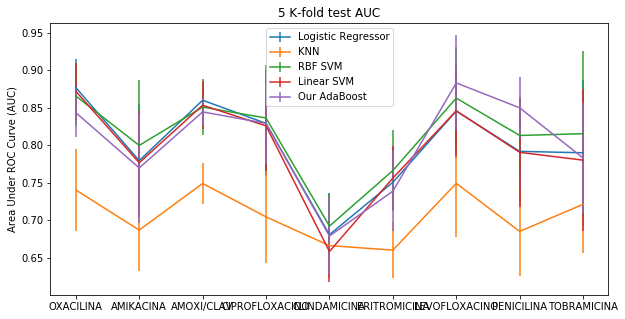

In [25]:
plt.figure(figsize=(10,5))
col_names = targets.columns.values
for i in range(len(list_of_best_clfs_list)):
    plt.errorbar(col_names,mean_test_auc[:,i],std_test_auc[:,i],label=labs[i])
plt.title(str(N)+' K-fold test AUC')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.legend()
plt.show()

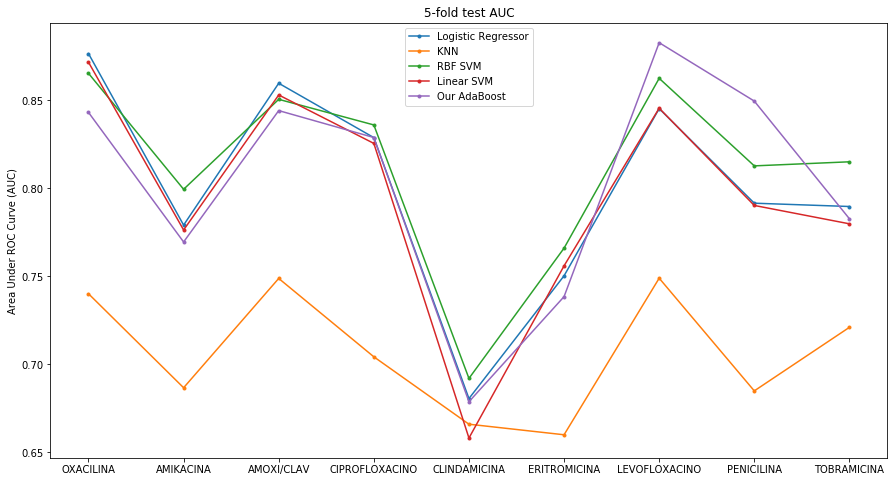

In [51]:
plt.figure(figsize=(15,8))
col_names = targets.columns.values
for i in range(len(list_of_best_clfs_list)):
    plt.plot(col_names,mean_test_auc[:,i],'.-',label=labs[i])
plt.title(str(N)+'-fold test AUC')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.legend()
plt.show()

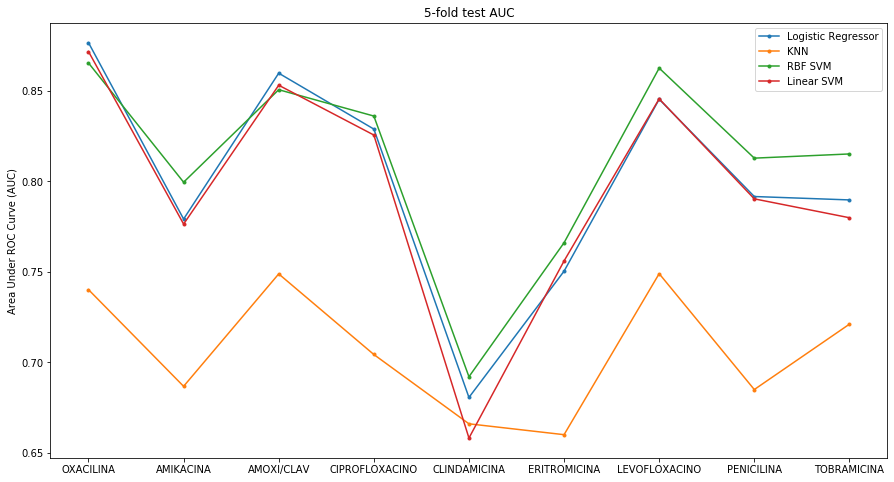

In [69]:
plt.figure(figsize=(15,8))
col_names = targets.columns.values
for i in range(len(list_of_best_clfs_list)-1):
    plt.plot(col_names,mean_test_auc[:,i],'.-',label=labs[i])
plt.title(str(N)+'-fold test AUC')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.legend()
plt.show()

In [27]:
for i in range(len(list_of_best_clfs_list)):
    print('Mean test AUC for '+labs[i]+': '+str(np.round(np.mean(mean_test_auc[:,i]),3)))

Mean test AUC for Logistic Regressor: 0.8
Mean test AUC for KNN: 0.707
Mean test AUC for RBF SVM: 0.811
Mean test AUC for Linear SVM: 0.795
Mean test AUC for Our AdaBoost: 0.802


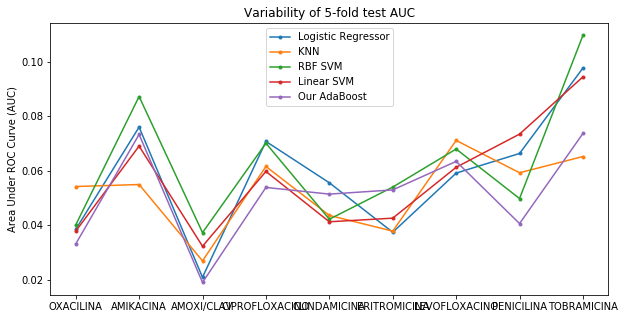

In [45]:
plt.figure(figsize=(10,5))
col_names = targets.columns.values
for i in range(len(list_of_best_clfs_list)):
    plt.plot(col_names,std_test_auc[:,i],'.-',label=labs[i])
plt.title('Variability of '+str(N)+'-fold test AUC')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.legend()
plt.show()

## Validation scores graph


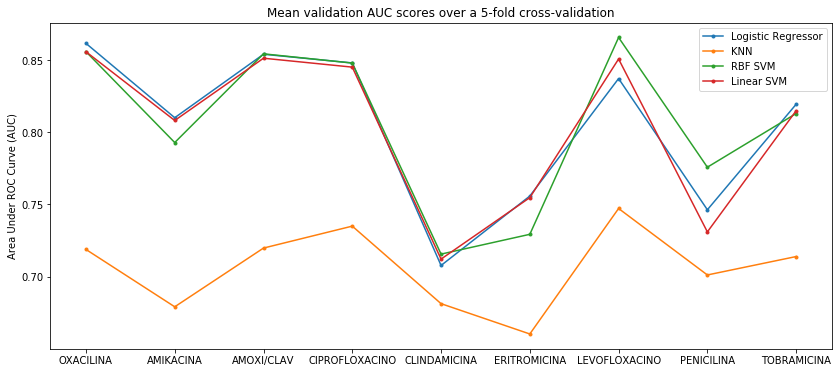

In [74]:
plt.figure(figsize=(14,6))
col_names = targets.columns.values
list_val_scores = [lr_AUC_validation, knn_AUC_validation, rbf_SVM_AUC_validation, linear_SVM_AUC_validation]
for i in range(len(list_val_scores)):
    plt.plot(col_names,list_val_scores[i],'.-',label=labs[i])
plt.title('Mean validation AUC scores over a 5-fold cross-validation')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.legend()
plt.show()

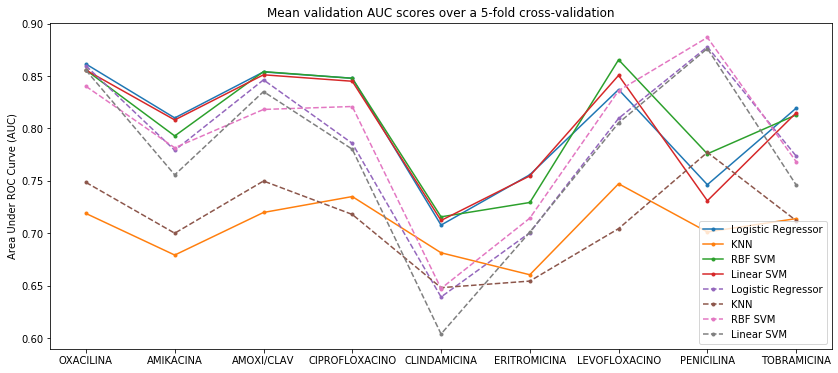

In [78]:
plt.figure(figsize=(14,6))
col_names = targets.columns.values
list_val_scores = [lr_AUC_validation, knn_AUC_validation, rbf_SVM_AUC_validation, linear_SVM_AUC_validation]
for i in range(len(list_val_scores)):
    plt.plot(col_names,list_val_scores[i],'.-',label=labs[i])
for i in range(len(list_val_scores)):
    plt.plot(col_names,list_testtrain_scores[i],'.--',label=labs[i])
plt.title('Mean validation AUC scores over a 5-fold cross-validation')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.legend()
plt.show()

## Test_train scores

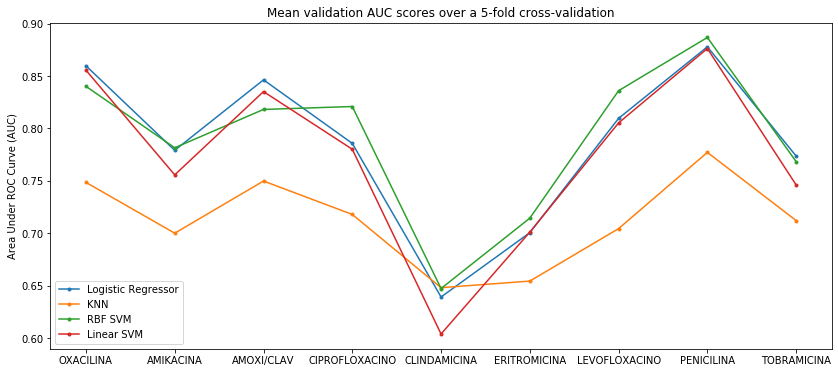

In [76]:
plt.figure(figsize=(14,6))
col_names = targets.columns.values
list_testtrain_scores = [lr_AUC_test, knn_AUC_test, rbf_SVM_AUC_test, linear_SVM_AUC_test]
for i in range(len(list_val_scores)):
    plt.plot(col_names,list_testtrain_scores[i],'.-',label=labs[i])
plt.title('Mean validation AUC scores over a 5-fold cross-validation')
plt.ylabel('Area Under ROC Curve (AUC)')
plt.legend()
plt.show()

## Save models

In [28]:
def save_clf(savepath,filename,clf_list):
  # filename must be without extension
  if (savepath[-1] != '/'): savepath = savepath + '/'
  with open(savepath+filename+'.data','wb') as filehandle:
    pickle.dump(clf_list,filehandle)

def load_clf(savepath,filename):
  if (savepath[-1] != '/'): savepath = savepath + '/'
  if os.path.isfile(savepath+filename+'.data'):
    with open(savepath+filename+'.data','rb') as filehandle:
      new_list = pickle.load(filehandle)
    print('Loaded!')
  else:
    print('File not found')
    new_list = []
  return new_list

In [29]:
# save all of this
mydict = {'listoflist':list_of_best_clfs_list,'labels':labs,'AUC_test':test_aucs}
save_clf(savepath,'dict_bs5_allclfs_10fold',mydict)

# Let's generate predictions and make late submissions

In [38]:
# def generate_csv_from_clf(clf_list, path, path_results, file_name):
  # classifiers must be provided with parameters, and in a list [clf_antibiotic0, clf_antibiotic1, ...]
  # spectrum and targets full train (containing all training points) will be used for training the clfs in clf list
  # df_test must be provided as loaded from the file

# read all data from files
# zf = zipfile.ZipFile(path+'zipped_TrainData.zip', 'r')
# df_fulltrain = _pickle.loads(zf.open('TrainData.pkl').read());   zf.close()
spectrum_fulltrain = spectrum_full_train
targets_fulltrain = targets_full_train

zf = zipfile.ZipFile(path+'zipped_TestDataUnlabeled.zip', 'r')
df_test = _pickle.loads(zf.open('TestDataUnlabeled.pkl').read());   zf.close()

df_test2 = remove_noise(df_test)
spectrum_test = spectrum_in_bins_6(df_test2,m,M,bin_size)
# # Process test df to get UNIQUE samples and convert to spectrum

# df_fulltrain = remove_noise(df_fulltrain)

# # Extract data (spectra) and targets of the df_train set
# data_fulltrain = df_fulltrain.iloc[:,-2:]
# targets_fulltrain = df_fulltrain.iloc[:,1:-2]

# bin_size = 5
# bin_size_lowarea = 5
# middle = 5000
# m = 2000 ; M = 12500;

# # magnif 5
# spectrum_fulltrain_5 = spectrum_in_bins_lowareamagnification(data_fulltrain,m,middle,M,bin_size_lowarea,bin_size)
# spectrum_test_5 = spectrum_in_bins_lowareamagnification(df_test,m,middle,M,bin_size_lowarea,bin_size)

# bin_size = 1; bin_size_lowarea = 1;
# # magnif 1
# spectrum_fulltrain_1 = spectrum_in_bins_lowareamagnification(data_fulltrain,m,middle,M,bin_size_lowarea,bin_size)
# spectrum_test_1 = spectrum_in_bins_lowareamagnification(df_test,m,middle,M,bin_size_lowarea,bin_size)

print('DONE!')

DONE!
DONE!


In [41]:
path_results = path + 'Kaggle_results/LateSubmissions/'
print(path_results)

C:/Users/Javi/Documents/GitHub/Machine-Learning/Kaggle/Kaggle_results/LateSubmissions/


In [61]:
def generate_csv_new(clf_list,savename):
    # spectra already generated; bin size 1
    categories = targets_fulltrain.columns[:]
    aux_list = [df_test['ID_sample'].values.tolist()]
    for c, cat in enumerate(categories): 
        print([cat])
        # clean NaN values
        X_train, Y_train = clean_nan_samples(spectrum_fulltrain,targets_fulltrain, c, cat)

      # metemos distintos spectros para dist categorieas
        # fit the classifier
        clf_base = clf_list[c].fit(X_train,Y_train)
        # Compute its test prestiction and save this output
        o_test = clf_base.predict_proba(spectrum_test)
        o_test = o_test[:,-1].tolist()
        aux_list.append(o_test)
    print('Training completed')
    df_submission = pd.read_csv(path+'SubmissionSample.csv')
    df_submission2 = pd.DataFrame.from_records(aux_list).transpose()
    df_submission2.columns = df_submission.columns.tolist()

    # drop duplicates
    df_submission3 = df_submission2.drop_duplicates(subset='ID')
    df_submission3 = df_submission3.set_index('ID')
    df_submission3.to_csv(path_results + savename + '.csv')
    
    # metodo Gini
    pred_test = df_submission2.copy()
    IDs = pd.DataFrame()
    IDs['ID_sample'] = pred_test['ID']
    pred_test = pred_test.drop(columns='ID')

    # when I have all_predictions_test
    N = pred_test.shape[0]
    C = pred_test.shape[1]

    # get unique ID samples
    ID_samples = IDs.drop_duplicates(subset='ID_sample')
    ID_samples = ID_samples[['ID_sample']].to_numpy().astype(int).reshape(-1,)

    # create empty matrix for new predictions
    new_predictions = np.zeros((len(ID_samples),pred_test.shape[1]))

    # for each ID sample, compare both predictions and take the better one
    for counter, id in enumerate(ID_samples):
        predictions = pred_test.loc[IDs['ID_sample'].to_numpy().astype(int)==id]
        L = len(predictions)
        if L > 1: # more than one spectrum for that sample
            decisivity_index = np.zeros((L,)) # decisivity index ~= Gini = sum( (1-value)*value) 
            # --> low for close to 1 or 0, high for close to 0.5
            for l in range(L):
                di = 0
                for c in range(C): # sum the decisivity index for all categories
                    val = predictions.iloc[l,c]
                    di += (1-val)*val
                decisivity_index[l] = di
            idx = np.argsort(decisivity_index)[0]
            new_predictions[counter,:] = predictions.iloc[idx,:]

        elif L==1: # just one prediction for that ID
            new_predictions[counter,:] = predictions 
        else:
            print('Weird, no sample for ID %d. Bug in code.' %id)

    # save those results in a df with ID sample as ID
    predictions_more_expressive = pd.DataFrame(data = new_predictions, columns = targets.columns)

    predictions_more_expressive['ID'] = ID_samples
    predictions_more_expressive = predictions_more_expressive.set_index('ID')
    predictions_more_expressive.to_csv(path_results + savename + '_Gini' + '.csv')
    
#     # Boolean outcome
#     matrix = predictions_more_expressive.to_numpy()
#     matrix[matrix>=0.5] = 1
#     matrix[matrix<0.5] = 0
#     boolean_df = pd.DataFrame(data=matrix, columns=predictions_more_expressive.columns, index=predictions_more_expressive.index)
#     boolean_df.to_csv(path_results + savename + '_boolean' + '.csv')
    print('Predictions generated')
    print('DONE!')

In [43]:
# list_of_best_clfs_list = [lr_best_clfs,knn_best_clfs,rbf_SVM_best_clfs,linear_SVM_best_clfs,ab_ours]
generate_csv_new(lr_best_clfs,'logreg_bs1_NEW')

['OXACILINA']
['AMIKACINA']
['AMOXI/CLAV']
['CIPROFLOXACINO']
['CLINDAMICINA']
['ERITROMICINA']
['LEVOFLOXACINO']
['PENICILINA']
['TOBRAMICINA']
DONE!


In [48]:
generate_csv_new(knn_best_clfs,'knn_bs1_LATE')

['OXACILINA']
['AMIKACINA']
['AMOXI/CLAV']
['CIPROFLOXACINO']
['CLINDAMICINA']
['ERITROMICINA']
['LEVOFLOXACINO']
['PENICILINA']
['TOBRAMICINA']
Training completed
Predictions generated
DONE!


In [50]:
generate_csv_new(rbf_SVM_best_clfs,'rbf_bs1_LATE')

['OXACILINA']
['AMIKACINA']
['AMOXI/CLAV']
['CIPROFLOXACINO']
['CLINDAMICINA']
['ERITROMICINA']
['LEVOFLOXACINO']
['PENICILINA']
['TOBRAMICINA']
Training completed
Predictions generated
DONE!


In [52]:
generate_csv_new(linear_SVM_best_clfs,'linear_SVM_bs1_LATE')

['OXACILINA']
['AMIKACINA']
['AMOXI/CLAV']
['CIPROFLOXACINO']
['CLINDAMICINA']
['ERITROMICINA']
['LEVOFLOXACINO']
['PENICILINA']
['TOBRAMICINA']
Training completed
Predictions generated
DONE!


In [62]:
ab_ours = [OurAdaBoostEnsemble(T=500)]*9
generate_csv_new(ab_ours,'AB_bs1_LATE')

['OXACILINA']
['AMIKACINA']
['AMOXI/CLAV']
['CIPROFLOXACINO']
['CLINDAMICINA']
['ERITROMICINA']
['LEVOFLOXACINO']
['PENICILINA']
['TOBRAMICINA']
Training completed
Predictions generated
DONE!


In [67]:
# put predictions btw 0 and 1
def normalize_predictions_ab(filename):
    df_submission = pd.read_csv(path_results+filename+'.csv')
    categories = targets_fulltrain.columns[:]
    for c, cat in enumerate(categories): 
        total_alpha = np.sum(ab_ours[c].alpha)
        print(total_alpha)
        print('Max value before:',np.max(df_submission.iloc[:,c]))
        df_submission.iloc[:,c] = df_submission.iloc[:,c]/total_alpha
        print('Max value after:',np.max(df_submission.iloc[:,c]))
        print('Min value:',np.min(df_submission.iloc[:,c]))
    df_submission.to_csv(path_results+filename+'_normalized'+'.csv')

In [68]:
normalize_predictions_ab('AB_bs1_LATE')

33.14023135188752
Max value before: 4794
Max value after: 144.6580124651711
Min value: 3.741675750037801
33.14023135188752
Max value before: 24.16955478800341
Max value after: 0.7293115890280838
Min value: 0.4750481148229076
33.14023135188752
Max value before: 19.611476081718163
Max value after: 0.5917724554629936
Min value: 0.3468181755744959
33.14023135188752
Max value before: 23.79485610697803
Max value after: 0.718005129605795
Min value: 0.47579558318492143
33.14023135188752
Max value before: 20.505547470548294
Max value after: 0.6187508847725768
Min value: 0.39613082177758874
33.14023135188752
Max value before: 19.93555785660332
Max value after: 0.6015515596413565
Min value: 0.4175227563373064
33.14023135188752
Max value before: 22.662073490374517
Max value after: 0.6838236356815229
Min value: 0.4818968335620395
33.14023135188752
Max value before: 20.773995273343967
Max value after: 0.6268512447231535
Min value: 0.39035009195407566
33.14023135188752
Max value before: 97.1241518374